In [ ]:
!pip install catboost
import pandas as pd
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH = '/content/drive/MyDrive/Zindi_VehicleInsuranceClaim/'
TRAIN_PATH = PATH + 'Train.csv'
TEST_PATH = PATH + 'Test.csv'
SAMPLE_SUBMISSION = PATH + 'SampleSubmission.csv'
STATE = PATH + 'NigerianStateNames.csv'

FOLD_LENGTH = 5


CATEGORICAL_COL = ['Gender','Car_Category',
                   'Subject_Car_Colour','Subject_Car_Make',
                   'LGA_Name','State','ProductName']

DATE_COL = ['Policy Start Date','First Transaction Date', 'Policy End Date']

In [ ]:
# Load files into a pandas dataframe
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
ss = pd.read_csv(SAMPLE_SUBMISSION)

In [ ]:
train['is_train'] = 1
test['is_train'] = 0

Concatenate train and test data

In [ ]:
all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the all_data dataframe is: {all_data.shape}')

The shape of the all_data dataframe is: (13281, 15)


Update State names From Statename files

In [ ]:
state_names = pd.read_csv(STATE)
state_names.drop_duplicates(subset=['LGA'],keep="last",inplace=True)
all_data = pd.merge(all_data.drop(['State'], axis=1), state_names[['LGA','State']], left_on=['LGA_Name'],
         right_on=["LGA"], how="left")
all_data.drop("LGA",axis=1,inplace=True)

Set data type of columns

In [ ]:
date_cols = [col for col in all_data.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol']
cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols+['ID', 'target','is_train']]

for col in all_data.columns:
  if col in date_cols:
    all_data[col] = pd.to_datetime(all_data[col])
  # elif col in cat_cols:
  #   all_data[col] = all_data[col].astype('category')

# Confirm whether the changes have been applied successfully
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13281 entries, 0 to 13280
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      13281 non-null  object        
 1   Policy Start Date       13281 non-null  datetime64[ns]
 2   Policy End Date         13281 non-null  datetime64[ns]
 3   Gender                  12881 non-null  object        
 4   Age                     13281 non-null  int64         
 5   First Transaction Date  13281 non-null  datetime64[ns]
 6   No_Pol                  13281 non-null  int64         
 7   Car_Category            9171 non-null   object        
 8   Subject_Car_Colour      5622 non-null   object        
 9   Subject_Car_Make        10557 non-null  object        
 10  LGA_Name                6149 non-null   object        
 11  ProductName             13281 non-null  object        
 12  target                  12079 non-null  float6

COMBINE Gender classes in to other

In [ ]:
all_data['Gender'].fillna("NOT STATED",inplace=True)
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':"Other"}
all_data.Gender = all_data.Gender.replace(mapper)

# Confirm mappings
all_data.Gender.value_counts()

Male      8356
Female    3679
Other     1246
Name: Gender, dtype: int64

# Fixing Anomalies in Age and Essential date features

In [ ]:
all_data['Age'].describe()

count    13281.000000
mean        42.375574
std         93.170951
min      -6099.000000
25%         35.000000
50%         41.000000
75%         50.000000
max        320.000000
Name: Age, dtype: float64

In [ ]:
#For Nigeria (West Africa), the minimum age for license is 18
all_data['Age'] = np.where(all_data['Age'] < 18, 18, all_data['Age'])
# The minimum age requirement for a driver is 18 and the maximum age allowed is 70. for Nigeria
all_data['Age'] = np.where(all_data['Age'] > 70, 70, all_data['Age'])

In [ ]:
## Binning ages in to group
high_risk_drivers = (((all_data['Age'] >= 18) & (all_data['Age'] <= 30)) | (all_data['Age'] > 60))
medium_risk_drivers = ((all_data['Age'] > 30) & (all_data['Age'] < 45))
low_risk_drivers = ((all_data['Age'] >= 45) & (all_data['Age'] <= 60))
all_data.loc[:,'risk_by_age'] = "None"
all_data['risk_by_age'] = np.where(high_risk_drivers,'high risk', all_data['risk_by_age'])
all_data['risk_by_age'] = np.where(medium_risk_drivers, 'medium risk', all_data['risk_by_age'])
all_data['risk_by_age'] = np.where(low_risk_drivers, 'low risk', all_data['risk_by_age'])

all_data['risk_by_age'] = all_data['risk_by_age'].astype('category')

# append in categorical columns
if 'risk_by_age' not in cat_cols:
  cat_cols.append("risk_by_age")

In [ ]:
# all_data['risk_by_age_Policy'] = np.log(all_data.groupby(['risk_by_age'])['No_Pol'].transform('max'))
# all_data['risk_by_age_Policy1'] = np.log(all_data.groupby(['risk_by_age'])['No_Pol'].transform('sum'))
# all_data['risk_by_age_Policy2'] = np.log(all_data.groupby(['risk_by_age'])['No_Pol'].transform('mean'))

In [ ]:
# Date Based Features

for col in date_cols:
  for date_feature in ['year', 'month', 'day','Dayofweek', 'Dayofyear']:
    all_data[col+date_feature+'1'] = getattr(all_data[col].dt, date_feature.lower())
    all_data[col+date_feature] = np.sin(getattr(all_data[col].dt, date_feature.lower()))

all_data['Age'] = np.log(all_data['Age'])

In [ ]:
# based on feature importance drop these features (redundant)
all_data.drop(['Policy Start DateDayofweek', 'Policy Start DateDayofyear',
       'Policy Start Dateday', 'Policy Start Datemonth',
       'Policy Start Dateyear'], axis=1, inplace=True)

In [ ]:
# create checkpoint
checkpoint = all_data.copy()

# Impute Missing Values

Mode imputer gave better results than KNN imputer

In [ ]:
all_data = checkpoint.copy()

In [ ]:
for col in all_data.columns:
  if col in date_cols+cat_cols:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
  elif col in num_cols:
    all_data[col] = all_data[col].fillna(all_data[col].fillna(9999))

# Confirm that there aren't any missing values
all_data[all_data.columns.difference(['target'])].isna().sum()

Age                                 0
Car_Category                        0
First Transaction Date              0
First Transaction DateDayofweek     0
First Transaction DateDayofweek1    0
First Transaction DateDayofyear     0
First Transaction DateDayofyear1    0
First Transaction Dateday           0
First Transaction Dateday1          0
First Transaction Datemonth         0
First Transaction Datemonth1        0
First Transaction Dateyear          0
First Transaction Dateyear1         0
Gender                              0
ID                                  0
LGA_Name                            0
No_Pol                              0
Policy End Date                     0
Policy End DateDayofweek            0
Policy End DateDayofweek1           0
Policy End DateDayofyear            0
Policy End DateDayofyear1           0
Policy End Dateday                  0
Policy End Dateday1                 0
Policy End Datemonth                0
Policy End Datemonth1               0
Policy End D

FEATURE ENGINEERING

In [ ]:
# all_data['Duration_of_policy(days)'] = np.log((all_data['Policy End Date'] - \
#                                                all_data['Policy Start Date']).dt.days)

In [ ]:
all_data['Gender_Age'] = np.log(all_data.groupby(['Gender'])['Age'].transform('std'))
all_data['Gender_Age2'] = np.log(all_data.groupby(['Gender'])['Age'].transform('max'))
all_data['Gender_Age3'] = np.log(all_data.groupby(['Gender'])['Age'].transform('mean'))

all_data['Gender_Policy'] = np.log(all_data.groupby(['Gender'])['No_Pol'].transform('max'))
all_data['Gender_Policy1'] = np.log(all_data.groupby(['Gender'])['No_Pol'].transform('sum'))
all_data['Gender_Policy2'] = np.log(all_data.groupby(['Gender'])['No_Pol'].transform('mean'))

# all_data['Gender_duration'] = np.log(all_data.groupby(['Gender'])['Duration_of_policy(days)'].transform('max'))
# all_data['Gender_duration1'] = np.log(all_data.groupby(['Gender'])['Duration_of_policy(days)'].transform('sum'))
# all_data['Gender_duration2'] = np.log(all_data.groupby(['Gender'])['Duration_of_policy(days)'].transform('mean'))

all_data['Car_Category_Age'] = np.log(all_data.groupby(['Car_Category'])['Age'].transform('std'))
all_data['Car_Category_Age2'] = np.log(all_data.groupby(['Car_Category'])['Age'].transform('max'))
all_data['Car_Category_Age3'] = np.log(all_data.groupby(['Car_Category'])['Age'].transform('mean'))

all_data['Car_Category_Policy'] = np.log(all_data.groupby(['Car_Category'])['No_Pol'].transform('max'))
all_data['Car_Category_Policy1'] = np.log(all_data.groupby(['Car_Category'])['No_Pol'].transform('sum'))
all_data['Car_Category_Policy2'] = np.log(all_data.groupby(['Car_Category'])['No_Pol'].transform('mean'))

# all_data['Car_Category_duration'] = np.log(all_data.groupby(['Car_Category'])['Duration_of_policy(days)'].transform('max'))
# all_data['Car_Category_duration1'] = np.log(all_data.groupby(['Car_Category'])['Duration_of_policy(days)'].transform('sum'))
# all_data['Car_Category_duration2'] = np.log(all_data.groupby(['Car_Category'])['Duration_of_policy(days)'].transform('mean'))

all_data['Subject_Car_Make_Age2'] = np.log(all_data.groupby(['Subject_Car_Make'])['Age'].transform('max'))
all_data['Subject_Car_Make_Age3'] = np.log(all_data.groupby(['Subject_Car_Make'])['Age'].transform('mean'))

all_data['Subject_Car_Make_Policy'] = np.log(all_data.groupby(['Subject_Car_Make'])['No_Pol'].transform('max'))
all_data['Subject_Car_Make_Policy1'] = np.log(all_data.groupby(['Subject_Car_Make'])['No_Pol'].transform('sum'))
all_data['Subject_Car_Make_Policy2'] = np.log(all_data.groupby(['Subject_Car_Make'])['No_Pol'].transform('mean'))

# all_data['Subject_Car_Make_duration'] = np.log(all_data.groupby(['Subject_Car_Make'])['Duration_of_policy(days)'].transform('max'))
# all_data['Subject_Car_Make_duration1'] = np.log(all_data.groupby(['Subject_Car_Make'])['Duration_of_policy(days)'].transform('sum'))
# all_data['Subject_Car_Make_duration2'] = np.log(all_data.groupby(['Subject_Car_Make'])['Duration_of_policy(days)'].transform('mean'))

# all_data['Subject_Car_Color_Age2'] = np.log(all_data.groupby(['Subject_Car_Colour'])['Age'].transform('max'))
# all_data['Subject_Car_Color_Age3'] = np.log(all_data.groupby(['Subject_Car_Colour'])['Age'].transform('mean'))

# all_data['Subject_Car_Colour_Policy'] = np.log(all_data.groupby(['Subject_Car_Colour'])['No_Pol'].transform('max'))
# all_data['Subject_Car_Colour_Policy1'] = np.log(all_data.groupby(['Subject_Car_Colour'])['No_Pol'].transform('sum'))
# all_data['Subject_Car_Colour_Policy2'] = np.log(all_data.groupby(['Subject_Car_Colour'])['No_Pol'].transform('mean'))

all_data['ProductName_Age'] = np.log(all_data.groupby(['ProductName'])['Age'].transform('std'))
all_data['ProductName_Age2'] = np.log(all_data.groupby(['ProductName'])['Age'].transform('max'))
all_data['ProductName_Age3'] = np.log(all_data.groupby(['ProductName'])['Age'].transform('mean'))

all_data['ProductName_Car_Category'] = np.log(all_data.groupby(['ProductName'])['Car_Category'].transform('count'))
all_data['ProductName_Car_Make'] = np.log(all_data.groupby(['ProductName'])['Subject_Car_Make'].transform('count'))

all_data['ProductName_Policy'] = np.log(all_data.groupby(['ProductName'])['No_Pol'].transform('max'))
all_data['ProductName_Policy1'] = np.log(all_data.groupby(['ProductName'])['No_Pol'].transform('sum'))
all_data['ProductName_Policy1'] = np.log(all_data.groupby(['ProductName'])['No_Pol'].transform('mean'))

# all_data['ProductName_duration'] = np.log(all_data.groupby(['ProductName'])['Duration_of_policy(days)'].transform('max'))
# all_data['ProductName_duration1'] = np.log(all_data.groupby(['ProductName'])['Duration_of_policy(days)'].transform('sum'))
# all_data['ProductName_duration2'] = np.log(all_data.groupby(['ProductName'])['Duration_of_policy(days)'].transform('mean'))


all_data['State_Age2'] = np.log(all_data.groupby(['State'])['Age'].transform('max'))
all_data['State_Age3'] = np.log(all_data.groupby(['State'])['Age'].transform('mean'))

all_data['State_Car_Category'] = np.log(all_data.groupby(['State'])['Car_Category'].transform('count'))
all_data['State_Car_Make'] = np.log(all_data.groupby(['State'])['Subject_Car_Make'].transform('count'))

all_data['State_Policy'] = np.log(all_data.groupby(['State'])['No_Pol'].transform('max'))
all_data['State_Policy2'] = np.log(all_data.groupby(['State'])['No_Pol'].transform('std'))
all_data['State_Policy1'] = np.log(all_data.groupby(['State'])['No_Pol'].transform('mean'))

# all_data['State_duration'] = np.log(all_data.groupby(['State'])['Duration_of_policy(days)'].transform('max'))
# all_data['State_duration1'] = np.log(all_data.groupby(['State'])['Duration_of_policy(days)'].transform('sum'))
# all_data['State_duration2'] = np.log(all_data.groupby(['State'])['Duration_of_policy(days)'].transform('mean'))


# Added duration of policy (new)
# Going to add for LGA
# all_data['LGA_Name_Age2'] = np.log(all_data.groupby(['LGA_Name'])['Age'].transform('max'))
# all_data['LGA_Name_Age2'] = np.log(all_data.groupby(['LGA_Name'])['Age'].transform('mean'))

# all_data['LGA_Name_Car_Category'] = np.log(all_data.groupby(['LGA_Name'])['Car_Category'].transform('count'))
# all_data['LGA_Name_Car_Make'] = np.log(all_data.groupby(['LGA_Name'])['Subject_Car_Make'].transform('count'))

# all_data['LGA_Name_Policy'] = np.log(all_data.groupby(['LGA_Name'])['No_Pol'].transform('max'))
# all_data['LGA_Name_Policy2'] = np.log(all_data.groupby(['LGA_Name'])['No_Pol'].transform('std'))
# all_data['LGA_Name_Policy1'] = np.log(all_data.groupby(['LGA_Name'])['No_Pol'].transform('mean'))

# all_data['LGA_Name_duration'] = np.log(all_data.groupby(['LGA_Name'])['Duration_of_policy(days)'].transform('max'))
# all_data['LGA_Name_duration1'] = np.log(all_data.groupby(['LGA_Name'])['Duration_of_policy(days)'].transform('sum'))
# all_data['LGA_Name_duration2'] = np.log(all_data.groupby(['LGA_Name'])['Duration_of_policy(days)'].transform('mean'))

# adding new from here
# all_data['state_lga_cm'] = np.log(all_data.groupby(['State','LGA_Name'])['Subject_Car_Make'].transform('count'))
# all_data['state_lga_gender_cm'] = np.log(all_data.groupby(['State','LGA_Name','Gender'])['Subject_Car_Make'].transform('count'))
# all_data['state_lga_cc'] = np.log(all_data.groupby(['State','LGA_Name','Gender','Car_Category'])['Subject_Car_Make'].transform('count'))
# all_data['state_lga_gender_cc'] = np.log(all_data.groupby(['State','LGA_Name','Gender'])['Car_Category'].transform('count'))
# all_data ['cm_cc_sc'] = np.log(all_data.groupby(['Subject_Car_Make','Car_Category','Subject_Car_Colour'])['Gender'].transform('count'))

# all_data['state_lga_cm_age'] = np.log(all_data.groupby(['State','LGA_Name'])['Age'].transform('mean'))
# all_data['state_lga_gender_cm_age'] = np.log(all_data.groupby(['State','LGA_Name','Gender'])['Age'].transform('mean'))
# all_data['state_lga_cc_age'] = np.log(all_data.groupby(['State','LGA_Name','Gender','Car_Category'])['Age'].transform('mean'))
# all_data['state_lga_gender_cc_age'] = np.log(all_data.groupby(['State','LGA_Name','Gender'])['Age'].transform('mean'))
# all_data ['cm_cc_sc_age'] = np.log(all_data.groupby(['Subject_Car_Make','Car_Category','Age'])['Age'].transform('mean'))



In [ ]:
# all_data['mean_age_cc_sc_cm'] = np.log(all_data.groupby(['Car_Category',\
#                                  'Subject_Car_Colour',\
#                                  'Subject_Car_Make'])['Age'].transform('mean'))
# all_data['count_age_cc_sc_cm'] = np.log(all_data.groupby(['Car_Category',\
#                                  'Subject_Car_Colour',\
#                                  'Subject_Car_Make'])['Age'].transform('count'))
# all_data['std_age_cc_sc_cm'] = np.log(all_data.groupby(['Car_Category',\
#                                  'Subject_Car_Colour',\
#                                  'Subject_Car_Make'])['Age'].transform('std'))


# all_data['mean_No_Pol_cc_sc_cm'] = np.log(all_data.groupby(['Car_Category',\
#                                  'Subject_Car_Colour',\
#                                  'Subject_Car_Make'])['No_Pol'].transform('mean'))
# all_data['count_No_Pol_cc_sc_cm'] = np.log(all_data.groupby(['Car_Category',\
#                                  'Subject_Car_Colour',\
#                                  'Subject_Car_Make'])['No_Pol'].transform('count'))
# all_data['std_No_Pol_cc_sc_cm'] = np.log(all_data.groupby(['Car_Category',\
#                                  'Subject_Car_Colour',\
#                                  'Subject_Car_Make'])['No_Pol'].transform('std'))


# all_data['mean_age_cc_lgas'] = np.log(all_data.groupby(['Car_Category',\
#                                  'LGA_Name',\
#                                  'ProductName',\
#                                  'State'])['Age'].transform('mean'))
# all_data['count_age_cc_lgas'] = np.log(all_data.groupby(['Car_Category',\
#                                  'LGA_Name',\
#                                  'ProductName',\
#                                  'State'])['Age'].transform('count'))
# all_data['std_age_cc_lgas'] = np.log(all_data.groupby(['Car_Category',\
#                                  'LGA_Name',\
#                                  'ProductName',\
#                                  'State'])['Age'].transform('std'))


# all_data['mean_No_Pol_cc_lgas'] = np.log(all_data.groupby(['Car_Category',\
#                                  'LGA_Name',\
#                                  'ProductName',\
#                                  'State'])['No_Pol'].transform('mean'))
# all_data['count_No_Pol_cc_lgas'] = np.log(all_data.groupby(['Car_Category',\
#                                  'LGA_Name',\
#                                  'ProductName',\
#                                  'State'])['No_Pol'].transform('count'))
# all_data['std_No_Pol_cc_lgas'] = np.log(all_data.groupby(['Car_Category',\
#                                  'LGA_Name',\
#                                  'ProductName',\
#                                  'State'])['No_Pol'].transform('std'))

In [ ]:
# concatenate categorical columns

# all_data['car_color_make'] = all_data['Car_Category'].astype('str') \
#                              + all_data['Subject_Car_Colour'].astype('str') \
#                              + all_data['Subject_Car_Make'].astype('str')
# cat_cols.append('car_color_make')

# all_data['lga_state'] = all_data['LGA_Name'].astype('str') \
#                             + all_data['State'].astype('str')
# cat_cols.append('lga_state')

# all_data['product_category'] = all_data['ProductName'].astype('str') \
#                                   + all_data['Car_Category'].astype('str')
# cat_cols.append('product_category')

# all_data['gender_lga_state'] =  all_data['Gender'].astype('str')\
#                                + all_data['State'].astype('str')\
#                                + all_data['LGA_Name'].astype('str')
# cat_cols.append('gender_lga_state')

# all_data['gender_car_category'] =  all_data['Gender'].astype('str')\
#                                + all_data['Car_Category'].astype('str')
# cat_cols.append('gender_car_category')

In [ ]:
s = pd.DataFrame(all_data.isnull().sum(), columns=['ss'])
s['ss'].value_counts()

0       69
1202     1
11       1
2        1
Name: ss, dtype: int64

In [ ]:
s[s['ss'] > 0]

,ss
target,1202
Car_Category_Age,2
State_Policy2,11


In [ ]:
# !pip install category-encoders

# Final features

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for col in cat_cols:
  all_data[col] = le.fit_transform(all_data[col])

In [ ]:
# train_df = all_data[all_data['is_train'] == 1]
# test_df = all_data[all_data['is_train'] == 0]

In [ ]:
# train_df.drop("is_train",axis=1,inplace=True)
# test_df.drop("is_train",axis=1,inplace=True)

In [ ]:
# main_cols = all_data.columns.difference(date_cols+['ID', 'target','is_train'])  # cols to remove

In [ ]:
# X = train_df[main_cols].fillna(-999).replace({np.inf:0,-np.inf:0})
# y = train_df.target
# test_df = test_df[main_cols].fillna(-999).replace({np.inf:0,-np.inf:0})
# import category_encoders as ce
# hce = ce.TargetEncoder(cols=cat_cols,smoothing=40,min_samples_leaf=7)
# X = hce.fit_transform(X,y)
# test_df = hce.transform(test_df)

In [ ]:
# main_cols = all_data.columns.difference(date_cols+cols_to_remove+['ID', 'target','is_train'])  # cols to remove

In [ ]:
# X = train_df[main_cols].fillna(-999).replace({np.inf:0,-np.inf:0})
# test_df = test_df[main_cols].fillna(-999).replace({np.inf:0,-np.inf:0})

In [ ]:
# ohe categorical features
all_data = pd.get_dummies(data = all_data, columns = cat_cols)

In [ ]:
main_cols = all_data.columns.difference(date_cols+['ID', 'target','is_train'])  # cols to remove

In [ ]:
train_df = all_data[all_data['is_train'] == 1]
test_df = all_data[all_data['is_train'] == 0]

In [ ]:
train_df.drop("is_train",axis=1,inplace=True)
test_df.drop("is_train",axis=1,inplace=True)

# Oversampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, RandomOverSampler, SMOTE

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# for col in cat_cols:
#   all_data[col] = le.fit_transform(all_data[col])

In [ ]:
X = train_df[main_cols].fillna(-999).replace({np.inf:0,-np.inf:0})
y = train_df.target

# us = RandomUnderSampler(0.2)  # 0.2
os = RandomOverSampler(0.95, random_state=0)   #0.95
# print(X.shape, y.shape)
# X, y = os.fit_resample(X, y)
# print(X.shape, y.shape)

In [ ]:
# new_cat = [X.columns.get_loc(col) for col in cat_cols if col not in cols_to_remove1]

In [ ]:
from collections import Counter
Counter(pd.DataFrame(y).isna().sum())

Counter({0: 1})

# Voting Classifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, \
                                                    random_state=42, \
                                                    stratify=y)

In [ ]:
## Individual feature importance for catboost, LGBM and XGBoost

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
cat = CatBoostClassifier(verbose=0)

In [ ]:
param_dist = { "learning_rate": np.linspace(0.05,0.95,15),
               "depth": [8,9,10,11,12],
               "l2_leaf_reg":[3,4,5,6,7,8],
               "iterations":[500,1000,1500],
               "scale_pos_weight":np.linspace(4,10,20)
              }
               
#Instantiate RandomSearchCV object
from sklearn.metrics import f1_score, make_scorer

f1 = make_scorer(f1_score , average='macro')
rscv_cat = RandomizedSearchCV(cat , param_dist, scoring=f1, cv =5)

In [ ]:
rscv_cat.fit(X_train,y_train)

# Print the tuned parameters and score


In [ ]:
print(rscv_cat.best_params_)
print(rscv_cat.best_score_)

{'scale_pos_weight': 5.894736842105263, 'learning_rate': 0.05, 'l2_leaf_reg': 7, 'iterations': 500, 'depth': 11}
0.6202566515895178


In [ ]:
y_pred = rscv_cat.predict(X_test)

In [ ]:
best_params = {'scale_pos_weight': 5.894736842105263, 'learning_rate': 0.05, 'l2_leaf_reg': 7, 'iterations': 500, 'depth': 11}

In [ ]:
catbst = CatBoostClassifier(**best_params, verbose=0)
catbst.fit(X_train, y_train)
y_pred = catbst.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      2656
         1.0       0.35      0.36      0.36       364

    accuracy                           0.84      3020
   macro avg       0.63      0.63      0.63      3020
weighted avg       0.84      0.84      0.84      3020



In [ ]:
col_imp = {}
for col,imp in zip(main_cols,catbst.feature_importances_):
  col_imp[col] = imp

In [ ]:
fi = pd.DataFrame(col_imp, index=[0]).T.sort_values(by=[0], ascending=False)
cols_to_remove= list(fi[fi[0]<1].index)


In [ ]:
lgb_cl = LGBMClassifier(verbose=0)
param_dist = { "learning_rate": np.linspace(0.05,0.95,15),
               "depth": [8,9,10,11,12],
               "l2_leaf_reg":[3,4,5,6,7,8],
               "iterations":[500,1000,1500],
               "scale_pos_weight":np.linspace(4,10,20)
              }
               
#Instantiate RandomSearchCV object
from sklearn.metrics import f1_score, make_scorer

f1 = make_scorer(f1_score , average='macro')
rscv_lgb = RandomizedSearchCV(lgb_cl , param_dist, scoring=f1, cv =5)

In [ ]:
rscv_lgb.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg_lambda=0.0, sile...
                                        'scale_pos_weight': array([ 4.        ,  4.31578947,  4.63157895,  4.94736842,  5.263

In [ ]:
print(rscv_lgb.best_params_)
print(rscv_lgb.best_score_)

{'scale_pos_weight': 4.947368421052632, 'learning_rate': 0.11428571428571428, 'l2_leaf_reg': 5, 'iterations': 1500, 'depth': 11}
0.6216856922408558


In [ ]:
y_pred = rscv_lgb.predict(X_test)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.85      0.88      2656
         1.0       0.31      0.51      0.39       364

    accuracy                           0.81      3020
   macro avg       0.62      0.68      0.64      3020
weighted avg       0.85      0.81      0.83      3020



In [ ]:
lgbbst = LGBMClassifier(**rscv_lgb.best_params_, verbose=0)
lgbbst.fit(X_train, y_train)
y_pred = lgbbst.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.85      0.88      2656
         1.0       0.31      0.51      0.39       364

    accuracy                           0.81      3020
   macro avg       0.62      0.68      0.64      3020
weighted avg       0.85      0.81      0.83      3020



In [ ]:
xgb_cl = XGBClassifier(verbose=0)
param_dist = { "learning_rate": np.linspace(0.05,0.95,15),
               "depth": [8,9,10,11,12],
               "l2_leaf_reg":[3,4,5,6,7,8],
               "iterations":[500,1000,1500],
               "scale_pos_weight":np.linspace(4,10,20)
              }
               
#Instantiate RandomSearchCV object
from sklearn.metrics import f1_score, make_scorer

f1 = make_scorer(f1_score , average='macro')
rscv_xgb = RandomizedSearchCV(xgb_cl , param_dist, scoring=f1, cv =5)

In [ ]:
rscv_xgb.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
                                        'scale_pos_weight': array([ 4.        ,  4.31578947,  4.63157895,  4.94736842,  5.26315789,
        5.57894737,  5.89473684,  6.21052632,

In [ ]:
print(rscv_xgb.best_params_)
print(rscv_xgb.best_score_)

{'scale_pos_weight': 4.631578947368421, 'learning_rate': 0.5642857142857143, 'l2_leaf_reg': 5, 'iterations': 1500, 'depth': 10}
0.62383523014259


In [ ]:
y_pred = rscv_xgb.predict(X_test)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.82      0.87      2656
         1.0       0.28      0.52      0.36       364

    accuracy                           0.78      3020
   macro avg       0.60      0.67      0.62      3020
weighted avg       0.85      0.78      0.81      3020



In [ ]:
xgbbst = XGBClassifier(**rscv_xgb.best_params_, verbose=0)
xgbbst.fit(X_train, y_train)
y_pred = xgbbst.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.82      0.87      2656
         1.0       0.28      0.52      0.36       364

    accuracy                           0.78      3020
   macro avg       0.60      0.67      0.62      3020
weighted avg       0.85      0.78      0.81      3020



In [ ]:
test_df = test_df[main_cols]
predictions_cat = catbst.predict(test_df)
predictions_lgb = lgbbst.predict(test_df)
predictions_xgb = xgbbst.predict(test_df)
# Create a submission file
sub_file = ss.copy()
sub_file.predictions_cat = predictions_cat
sub_file.predictions_lgb = predictions_lgb
sub_file.predictions_xgb = predictions_xgb

In [ ]:
sub_file.loc[:,'predictions_cat'] = predictions_cat
sub_file.loc[:,'predictions_lgb'] = predictions_lgb
sub_file.loc[:,'predictions_xgb'] = predictions_xgb

In [ ]:
sub_file.drop("target",axis=1,inplace=True)

In [ ]:
sub_file['target'] = sub_file[['predictions_cat','predictions_lgb','predictions_xgb']].mode(axis=1).iloc[:,0]

In [ ]:
sub_file["target"] = sub_file["target"].astype("int")

In [ ]:
sub_file['target'].value_counts()

0    1046
1     156
Name: target, dtype: int64

In [ ]:
sub_file[['ID','target']].to_csv("tuned_model.csv",index=False)

In [ ]:
ss['target'].value_counts()

0    1150
1      52
Name: target, dtype: int64

In [ ]:
# print(classification_report(testy, yhat))

In [ ]:
# !pip install pytorch-tabnet

In [ ]:
# BS=1024
# MAX_EPOCH=101

# N_D = 128
# N_A = 48  #32
# N_INDEP = 1
# N_SHARED = 1
# N_STEPS = 3

# tabnet_params = dict(n_d=N_D, n_a=N_A, n_steps=N_STEPS,  #0.2,
#                          n_independent=N_INDEP, n_shared=N_SHARED,
#                          lambda_sparse=0., optimizer_fn=torch.optim.Adam,
#                          optimizer_params=dict(lr=2e-2),
#                          mask_type="entmax",
#                          scheduler_params=dict(mode="min",
#                                                patience=5,
#                                                min_lr=1e-5,
#                                                factor=0.9,),
#                          scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,                         
#                          verbose=10,
#                          )

# pretrainer = TabNetPretrainer(**tabnet_params)
# #test_features.values[:,1:]  on 25th Nov
# pretrainer.fit(X_train=X_train.values, #  np.vstack([train.values[:,1:], test.values[:,1:]])
#           max_epochs=MAX_EPOCH,
#           patience=20, batch_size=BS, virtual_batch_size=128, #128,
#           num_workers=0, drop_last=True,
#           pretraining_ratio=0.8)

In [ ]:
# MAX_EPOCH=200
# BS=1024

# tabnet_params = dict(n_d=N_D, n_a=N_A, n_steps=N_STEPS,
#                       n_independent=N_INDEP, n_shared=N_SHARED,
#                       gamma=1.0,
#                       lambda_sparse=0., optimizer_fn=torch.optim.Adam, # 
#                       optimizer_params=dict(lr=2e-2, # 2e-2
#                                             weight_decay=1e-5
#                                           ),
#                       mask_type="entmax",
#                       scheduler_params=dict(max_lr=0.05,
#                                           steps_per_epoch=int(X_train.shape[0] / BS),
#                                           epochs=MAX_EPOCH,
#                                           is_batch_level=True),
#                       scheduler_fn=torch.optim.lr_scheduler.OneCycleLR,
#                       verbose=10,
#                       )

# model = TabNetClassifier(**tabnet_params)

# model.fit(X_train=X_train.values,
#           y_train=y_train.values,
#           eval_set=[(X_test.values, y_test.values)],
#           eval_name = ["val"],
#           eval_metric = ["auc"],
#           max_epochs=MAX_EPOCH,
#           patience=20, batch_size=BS, virtual_batch_size=128, #128,
#           num_workers=1, drop_last=True,
#           from_unsupervised=pretrainer)

In [ ]:
# y_prediction = model.predict(X_test.values)

In [ ]:
# from sklearn.metrics import classification_report
# print(classification_report(y_test,y_prediction))

In [ ]:
# from pytorch_tabnet.tab_model import TabNetClassifier

In [ ]:
main_cols = all_data.columns.difference(date_cols+cols_to_remove+['ID', 'target','is_train'])  # cols to remove

In [ ]:
train_df = all_data[all_data['is_train'] == 1]
test_df = all_data[all_data['is_train'] == 0]

In [ ]:
train_df.drop("is_train",axis=1,inplace=True)
test_df.drop("is_train",axis=1,inplace=True)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, RandomOverSampler, SMOTE

In [ ]:
X = train_df[main_cols].fillna(-999).replace({np.inf:0,-np.inf:0})
y = train_df.target

# us = RandomUnderSampler(0.2)  # 0.2
os = RandomOverSampler(0.95, random_state=0)   #0.95
# print(X.shape, y.shape)
# X, y = os.fit_resample(X, y)
# print(X.shape, y.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, \
                                                    random_state=42, \
                                                    stratify=y)

In [ ]:
import xgboost as xg


from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
# Train model

xgb = xg.XGBClassifier(n_estimators=1000,
                      max_depth=6,
                      learning_rate=0.04,
                      subsample=0.9,
                      colsample_bytree=0.35,
                       objective = 'binary:logistic',
                       random_state = 1,
                       scale_pos_weight = 8,
                       )      


cat = CatBoostClassifier(iterations=1000,od_type="Iter",\
                            l2_leaf_reg=5,
                            learning_rate=0.95,\
                            verbose=0,\
                            random_state=0,
                            depth=10,
                            scale_pos_weight=8)  # iteration 220

lgb = LGBMClassifier(learning_rate=0.5,n_estimators=1000,random_state=0,
                       num_leaves=120,n_jobs =4,min_child_samples= 14,
                      min_child_weight= 10)  # gave scale pos weight

# X_train, y_train = os.fit_resample(X_train, y_train)
model = VotingClassifier(estimators=[('cat', catbst),\
                                     ('lgbm',lgb),\
                                     ('xgb',xgbbst)], voting='hard')
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
#y_pred_tab = model6.predict(X_test)
# Check the f1 score of the model
print(f'F1 score on the X_test is: {f1_score(y_test, y_pred)}')
from sklearn.metrics import matthews_corrcoef
print(matthews_corrcoef(y_test,y_pred))

F1 score on the X_test is: 0.3100558659217877
0.21733734170243366


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      2656
         1.0       0.32      0.30      0.31       364

    accuracy                           0.84      3020
   macro avg       0.61      0.61      0.61      3020
weighted avg       0.83      0.84      0.84      3020



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(final['test'],final['pred']))

              precision    recall  f1-score   support

         0.0       0.93      0.80      0.86      2656
         1.0       0.27      0.53      0.36       364

    accuracy                           0.77      3020
   macro avg       0.60      0.67      0.61      3020
weighted avg       0.85      0.77      0.80      3020



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      2656
         1.0       0.34      0.33      0.34       364

    accuracy                           0.84      3020
   macro avg       0.63      0.62      0.62      3020
weighted avg       0.84      0.84      0.84      3020



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92      2656
         1.0       0.32      0.22      0.26       364

    accuracy                           0.85      3020
   macro avg       0.61      0.58      0.59      3020
weighted avg       0.83      0.85      0.84      3020



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.92      0.91      2656
         1.0       0.34      0.31      0.32       364

    accuracy                           0.84      3020
   macro avg       0.62      0.61      0.62      3020
weighted avg       0.84      0.84      0.84      3020



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.92      0.91      2656
         1.0       0.33      0.31      0.32       364

    accuracy                           0.84      3020
   macro avg       0.62      0.61      0.62      3020
weighted avg       0.84      0.84      0.84      3020



In [ ]:
cat = CatBoostClassifier(iterations=1000,od_type="Iter",\
                            l2_leaf_reg=5,
                            learning_rate=0.95,\
                            verbose=0,\
                            random_state=0,
                            depth=10,
                            scale_pos_weight=8)

In [ ]:
cat.fit(X_train, y_train)

In [ ]:
col_imp = {}
for col,imp in zip(main_cols,cat.feature_importances_):
  col_imp[col] = imp

In [ ]:
fi = pd.DataFrame(col_imp, index=[0]).T.sort_values(by=[0], ascending=False)
cols_to_remove= list(fi[fi[0]<1].index)


In [ ]:
fi[0].sort_values(ascending=False)[:30]

ProductName                         10.451690
Age                                  8.427904
Subject_Car_Colour                   6.066664
LGA_Name                             5.447369
First Transaction DateDayofyear      4.919952
Policy End DateDayofyear             4.799044
Policy End Dateday1                  4.744387
Policy End Dateday                   3.826958
Policy Start DateDayofyear1          3.433189
First Transaction Dateday            3.350644
Policy End DateDayofyear1            2.882017
First Transaction DateDayofyear1     2.801545
Policy Start Dateday1                2.362044
risk_by_age                          2.278481
First Transaction DateDayofweek1     2.058673
Gender_Policy1                       1.829572
First Transaction DateDayofweek      1.789873
Subject_Car_Make_Policy              1.768586
Policy End DateDayofweek1            1.658947
Subject_Car_Make_Age3                1.643147
Gender_Age3                          1.409112
Policy Start DateDayofweek1       

In [ ]:
fi[0].describe()

count    30.000000
mean      3.333333
std       1.813688
min       0.512740
25%       2.239141
50%       2.933483
75%       4.543781
max       9.039975
Name: 0, dtype: float64

In [ ]:
# set(cols_to_remove1) - set(cols_to_remove)

In [ ]:
model.fit(X, y)  ## full dataset

VotingClassifier(estimators=[('cat',
                              <catboost.core.CatBoostClassifier object at 0x7fc1ce7cb650>),
                             ('lgbm',
                              LGBMClassifier(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.5, max_depth=-1,
                                             min_child_samples=14,
                                             min_child_weight=10,
                                             min_split_gain=0.0,
                                             n_estimators=1000, n_jobs=4,
                                             num_leaves=120, objective=None,
                                             r...
                                            learning_rate=0.5642857142857143,
          

In [ ]:
# y_pred = model.predict(X_test)
#y_pred_tab = model6.predict(X_test)
# Check the f1 score of the model
print(f'F1 score on the X_test is: {f1_score(y_test, y_pred)}')

F1 score on the X_test is: 0.3333333333333333


# Prediction with submission file

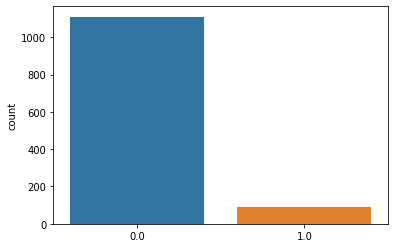

In [ ]:
# Make prediction on the test set
test_df = test_df[main_cols]
predictions = model.predict(test_df)

# Create a submission file
sub_file = ss.copy()
sub_file.predictions = predictions

# Check the distribution of your predictions
sns.countplot(sub_file.predictions)

In [ ]:
ss["target"] = predictions.astype("int")

In [ ]:
ss['target'].value_counts()

0    1110
1      92
Name: target, dtype: int64

In [ ]:
ss['target'].value_counts()

0    1110
1      92
Name: target, dtype: int64

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
ss.to_csv("model.csv",index=False)

In [ ]:
# 40.5 value

FOLD

In [ ]:
from collections import defaultdict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (classification_report,
                             accuracy_score,
                             confusion_matrix,
                             matthews_corrcoef,
                             precision_recall_curve,
                             roc_curve,auc,
                             roc_auc_score,
                            f1_score)

def split_k_folds(df, n_splits=10):
  df['kfold'] = -1

  kf = StratifiedKFold(n_splits=10)

  for f, (train_idx, valid_idx) in enumerate(kf.split(X = df, y = df['target'].values)):
    df.loc[valid_idx,'kfold'] = f
  return df


# create kfolds in training data
train_df = split_k_folds(train_df, FOLD_LENGTH)

In [ ]:
def evaluate_model(y_true, y_pred_proba, y_pred, set_threshold = False):
    metrics = {}
    
    if set_threshold:
        # get thresholds
        fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
        # get the best threshold
        J = tpr - fpr
        ix = np.argmax(J)
        # pick best threshold
        best_thresh = thresholds[ix]
#         print('updating prediction')
        # predict label based on threshold        
        y_pred = np.where(y_pred_proba>=0.5, 1, 0)
        
    #### based on probability #######
    # pr auc curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    metrics['pr_auc'] = auc(recall, precision)
    
    # ROC AUC score
    roc_auc = roc_auc_score(y_true,y_pred_proba)
    metrics['auc'] = roc_auc
    
    ### based on predictions ########
    # accuracy score
    acc = accuracy_score(y_true, y_pred)
    metrics['accuracy'] = acc
    
    # MCC
    mcc = matthews_corrcoef(y_true, y_pred)
    metrics['mcc'] = mcc
    
    # F1 score
    f1_val = f1_score(y_true, y_pred)
    metrics['f1'] = f1_val
    
    # outcome values order in sklearn (TPR and TNR)
    tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()
    sensitivity = tp/(tp + fn)
    metrics['sensitivity_tpr'] = sensitivity
    specificity = tn/(tn+fp)
    metrics['specificity_tnr'] = specificity
    metrics['r1_avg'] = np.mean([specificity,sensitivity])
    
    return metrics

In [ ]:

model= LGBMClassifier(learning_rate=0.5,n_estimators=1000,
                       num_leaves=120,n_jobs =4,min_child_samples= 14,
                      min_child_weight= 10)
eval_metrics = defaultdict(list)

for fold in range(FOLD_LENGTH):
  x_train = train_df[train_df['kfold']!=fold][main_cols]
  x_val = train_df[train_df['kfold']==fold][main_cols]
  x_test = train_df[main_cols]

  y_train = train_df[train_df['kfold']!=fold]['target']
  y_val = train_df[train_df['kfold']==fold]['target']

  oversample = SMOTE()
  x_train1, y_train1 = oversample.fit_resample(x_train, y_train)
  # x_train1 = pd.DataFrame(x_train1, columns=x_train.columns)
  model.fit(x_train1, y_train1)
  val_pred = model.predict(x_val)
  test_pred = model.predict(x_test)
  pred.append(test_pred)
  val_pred_proba = model.predict_proba(x_val)[:,1]
  eval_metrics['lgbm'].append(evaluate_model(y_val, val_pred_proba, val_pred))

In [ ]:
pd.DataFrame(eval_metrics['lgbm'])

,pr_auc,auc,accuracy,mcc,f1,sensitivity_tpr,specificity_tnr,r1_avg
0,0.229222,0.745042,0.834437,0.129410,0.218750,0.193103,0.921919,0.557511
1,0.216214,0.727447,0.824503,0.117043,0.214815,0.200000,0.909690,0.554845
2,0.233338,0.730953,0.826987,0.142981,0.240000,0.227586,0.908749,0.568168
3,0.276332,0.768109,0.841887,0.207298,0.295203,0.275862,0.919097,0.597479
4,0.263538,0.742267,0.837748,0.152914,0.240310,0.212329,0.923729,0.568029


Note to myself

Used same features
Included sine for date features <br>
Added log for all numerical values <br>
Included xgboost <br>
selected columns to remove using catboost model <br>
And trained model on this columns alone using voting classifier hard(approach)
 <br>


In [ ]:
cols_to_remove

NameError: ignored

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
f1 = pd.read_csv("/content/no_features__1_.csv")  # 40.5
f2 = pd.read_csv("/content/no_features__4_.csv")  #43
f3 = pd.read_csv("/content/outputs_top3.csv") #41.6
#f4 = pd.read_csv("/content/submission_new_attempt3_groupedfe.csv")  #0.4
f4 = pd.read_csv("/content/model.csv")  #40.9

In [ ]:
final_df = pd.DataFrame()
final_df['t1'] = f1['target']
final_df['t2'] = f2['target']
final_df['t3'] = f3['target']
final_df['t4'] = f4['target']

In [ ]:
final_df['target'] = final_df[['t1','t2','t3','t4']].mode(axis=1).iloc[:,0]

In [ ]:
f1.drop("target",axis=1,inplace=True)
f1.loc[:,'target'] = final_df['target']
f1.to_csv("submission_file_v4.csv",index=False)

In [ ]:
f1['target'].value_counts()

0.0    1144
1.0      58
Name: target, dtype: int64

In [ ]:
f1 = pd.read_csv("/content/submission_file_v4 (1).csv")  # 40.5
f2 = pd.read_csv("/content/no_features__4_ (1).csv")  #43
f3 = pd.read_csv("/content/submission_file (1).csv") #41.6
#f4 = pd.read_csv("/content/submission_new_attempt3_groupedfe.csv")  #0.4
# f4 = pd.read_csv("/content/model.csv")  #40.9

In [ ]:
final_df = pd.DataFrame()
final_df['t1'] = f1['target']
final_df['t2'] = f2['target']
final_df['t3'] = f3['target']

In [ ]:
final_df['target'] = final_df[['t1','t2','t3']].mode(axis=1).iloc[:,0]

In [ ]:
f1.drop("target",axis=1,inplace=True)
f1.loc[:,'target'] = final_df['target']
f1.to_csv("submission_file_v5.csv",index=False)

In [ ]:
f1['target'].value_counts()

0.0    1138
1.0      64
Name: target, dtype: int64